In [ ]:
import copy
import logging
import os
from typing import Any, Dict, Tuple, Union

import numpy as np
import optuna
from optuna.integration import PyTorchLightningPruningCallback, TensorBoardCallback
import optuna.logging
import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import statsmodels.api as sm
import torch
from torch.utils.data import DataLoader

from pytorch_forecasting import DeepAR
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss, NormalDistributionLoss

optuna_logger = logging.getLogger("optuna")


class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)


def optimize_hyperparameters(
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        model_path: str,
        max_epochs: int = 20,
        n_trials: int = 100,
        timeout: float = 3600 * 2.0,  # 2 hours
        gradient_clip_val_range: Tuple[float, float] = (0.01, 100.0),
        hidden_size_range: Tuple[int, int] = (16, 265),
        dropout_range: Tuple[float, float] = (0.1, 0.3),
        learning_rate_range: Tuple[float, float] = (1e-5, 1.0),
        rnn_layers_range: Tuple[int, int] = (2, 4),
        use_learning_rate_finder: bool = True,
        trainer_kwargs: Dict[str, Any] = {},
        log_dir: str = "lightning_logs",
        study: optuna.Study = None,
        verbose: Union[int, bool] = None,
        pruner: optuna.pruners.BasePruner = optuna.pruners.SuccessiveHalvingPruner(),
        **kwargs,
) -> optuna.Study:
    """
    Optimize Temporal Fusion Transformer hyperparameters.

    Run hyperparameter optimization. Learning rate for is determined with
    the PyTorch Lightning learning rate finder.

    Args:
        train_dataloader (DataLoader): dataloader for training model
        val_dataloader (DataLoader): dataloader for validating model
        model_path (str): folder to which model checkpoints are saved
        max_epochs (int, optional): Maximum number of epochs to run training. Defaults to 20.
        n_trials (int, optional): Number of hyperparameter trials to run. Defaults to 100.
        timeout (float, optional): Time in seconds after which training is stopped regardless of number of epochs
            or validation metric. Defaults to 3600*8.0.
        hidden_size_range (Tuple[int, int], optional): Minimum and maximum of ``hidden_size`` hyperparameter. Defaults
            to (16, 265).
        dropout_range (Tuple[float, float], optional):  Minimum and maximum of ``dropout`` hyperparameter. Defaults to
            (0.1, 0.3).
        learning_rate_range (Tuple[float, float], optional): Learning rate range. Defaults to (1e-5, 1.0).
        use_learning_rate_finder (bool): If to use learning rate finder or optimize as part of hyperparameters.
            Defaults to True.
        trainer_kwargs (Dict[str, Any], optional): Additional arguments to the
            `PyTorch Lightning trainer <https://pytorch-lightning.readthedocs.io/en/latest/trainer.html>`_ such
            as ``limit_train_batches``. Defaults to {}.
        log_dir (str, optional): Folder into which to log results for tensorboard. Defaults to "lightning_logs".
        study (optuna.Study, optional): study to resume. Will create new study by default.
        verbose (Union[int, bool]): level of verbosity.
            * None: no change in verbosity level (equivalent to verbose=1 by optuna-set default).
            * 0 or False: log only warnings.
            * 1 or True: log pruning events.
            * 2: optuna logging level at debug level.
            Defaults to None.
        pruner (optuna.pruners.BasePruner, optional): The optuna pruner to use.
            Defaults to optuna.pruners.SuccessiveHalvingPruner().

        **kwargs: Additional arguments for the :py:class:`~TemporalFusionTransformer`.

    Returns:
        optuna.Study: optuna study results
    """
    assert isinstance(train_dataloader.dataset, TimeSeriesDataSet) and isinstance(
        val_dataloader.dataset, TimeSeriesDataSet
    ), "dataloaders must be built from timeseriesdataset"

    logging_level = {
        None: optuna.logging.get_verbosity(),
        0: optuna.logging.WARNING,
        1: optuna.logging.INFO,
        2: optuna.logging.DEBUG,
    }
    optuna_verbose = logging_level[verbose]
    optuna.logging.set_verbosity(optuna_verbose)

    loss = kwargs.get(
        "loss", QuantileLoss()
    )  # need a deepcopy of loss as it will otherwise propagate from one trial to the next

    # create objective function
    def objective(trial: optuna.Trial) -> float:
        # Filenames for each trial must be made unique in order to access each checkpoint.
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=os.path.join(model_path, "trial_{}".format(trial.number)), filename="{epoch}", monitor="val_loss"
        )

        # The default logger in PyTorch Lightning writes to event files to be consumed by
        # TensorBoard. We don't use any logger here as it requires us to implement several abstract
        # methods. Instead we setup a simple callback, that saves metrics from each validation step.
        metrics_callback = MetricsCallback()
        learning_rate_callback = LearningRateMonitor()
        logger = TensorBoardLogger(log_dir, name="optuna", version=trial.number)
        gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
        default_trainer_kwargs = dict(
            gpus=[0] if torch.cuda.is_available() else None,
            max_epochs=max_epochs,
            gradient_clip_val=gradient_clip_val,
            callbacks=[
                metrics_callback,
                learning_rate_callback,
                checkpoint_callback,
                PyTorchLightningPruningCallback(trial, monitor="val_loss"),
            ],
            logger=logger,
            progress_bar_refresh_rate=[0, 1][optuna_verbose < optuna.logging.INFO],
            weights_summary=[None, "top"][optuna_verbose < optuna.logging.INFO],
        )
        default_trainer_kwargs.update(trainer_kwargs)
        trainer = pl.Trainer(
            **default_trainer_kwargs,
        )

        # create model
        hidden_size = trial.suggest_int("hidden_size", *hidden_size_range, log=True)
        rnn_layers = trial.suggest_int('rnn_layers', *rnn_layers_range)
        dropout = trial.suggest_uniform('dropout', *dropout_range)
        kwargs["loss"] = copy.deepcopy(loss)
        model = DeepAR.from_dataset(
            train_dataloader.dataset,
            cell_type='GRU',
            rnn_layers=rnn_layers,
            dropout=dropout,
            hidden_size=hidden_size,
            log_interval=-1,
            **kwargs,
        )
        # find good learning rate
        if use_learning_rate_finder:
            lr_trainer = pl.Trainer(
                gradient_clip_val=gradient_clip_val,
                gpus=[0] if torch.cuda.is_available() else None,
                logger=False,
                progress_bar_refresh_rate=0,
                weights_summary=None,
            )
            res = lr_trainer.tuner.lr_find(
                model,
                train_dataloader=train_dataloader,
                val_dataloaders=val_dataloader,
                early_stop_threshold=10000,
                min_lr=learning_rate_range[0],
                num_training=100,
                max_lr=learning_rate_range[1],
            )

            loss_finite = np.isfinite(res.results["loss"])
            if loss_finite.sum() > 3:  # at least 3 valid values required for learning rate finder
                lr_smoothed, loss_smoothed = sm.nonparametric.lowess(
                    np.asarray(res.results["loss"])[loss_finite],
                    np.asarray(res.results["lr"])[loss_finite],
                    frac=1.0 / 10.0,
                )[min(loss_finite.sum() - 3, 10) : -1].T
                optimal_idx = np.gradient(loss_smoothed).argmin()
                optimal_lr = lr_smoothed[optimal_idx]
            else:
                optimal_idx = np.asarray(res.results["loss"]).argmin()
                optimal_lr = res.results["lr"][optimal_idx]
            optuna_logger.info(f"Using learning rate of {optimal_lr:.3g}")
            # add learning rate artificially
            model.hparams.learning_rate = trial.suggest_uniform("learning_rate", optimal_lr, optimal_lr)
        else:
            model.hparams.learning_rate = trial.suggest_loguniform("learning_rate", *learning_rate_range)

        # fit
        trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

        # report result
        return metrics_callback.metrics[-1]["val_loss"].item()

    # setup optuna and run
    if study is None:
        study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    return study


,ds,cnp_np,cnp_se,cnp_se1,cnp_se2,cnp_se3,cnp_se4,cnp_no,cnp_no1,cnp_no2,cnp_no3,cnp_no4,cnp_no5,cnp_dk,cnp_dk1,cnp_dk2,cnp_fi
9024,2021-12-12 00:00:00,48.17,16.79,1.36,1.97,10.59,2.87,16.97,4.51,4.58,3.42,2.38,2.09,3.87,2.32,1.55,10.54
9025,2021-12-12 01:00:00,47.39,16.58,1.36,1.95,10.45,2.81,16.76,4.36,4.52,3.50,2.34,2.03,3.76,2.22,1.54,10.29
9026,2021-12-12 02:00:00,46.75,16.41,1.35,1.95,10.31,2.79,16.54,4.26,4.47,3.51,2.26,2.04,3.68,2.20,1.48,10.12
9027,2021-12-12 03:00:00,46.60,16.43,1.41,2.01,10.22,2.79,16.53,4.23,4.52,3.57,2.17,2.04,3.55,2.11,1.45,10.08
9028,2021-12-12 04:00:00,46.68,16.47,1.36,2.04,10.26,2.81,16.58,4.24,4.57,3.53,2.21,2.03,3.50,2.09,1.41,10.13
9029,2021-12-12 05:00:00,47.13,16.62,1.38,2.09,10.29,2.86,16.68,4.30,4.58,3.46,2.30,2.03,3.52,2.09,1.43,10.30
9030,2021-12-12 06:00:00,47.85,17.03,1.29,2.22,10.58,2.94,16.80,4.42,4.53,3.49,2.30,2.05,3.66,2.17,1.49,10.36
9031,2021-12-12 07:00:00,49.25,17.61,1.44,2.21,10.93,3.03,17.02,4.55,4.52,3.50,2.35,2.09,3.94,2.34,1.60,10.67
9032,2021-12-12 08:00:00,50.40,18.05,1.32,2.25,11.38,3.11,17.41,4.73,4.66,3.54,2.34,2.16,4.20,2.51,1.69,10.73
9033,2021-12-12 09:00:00,52.18,18.75,1.41,2.34,11.76,3.23,18.08,4.93,4.94,3.60,2.37,2.25,4.54,2.72,1.82,10.82


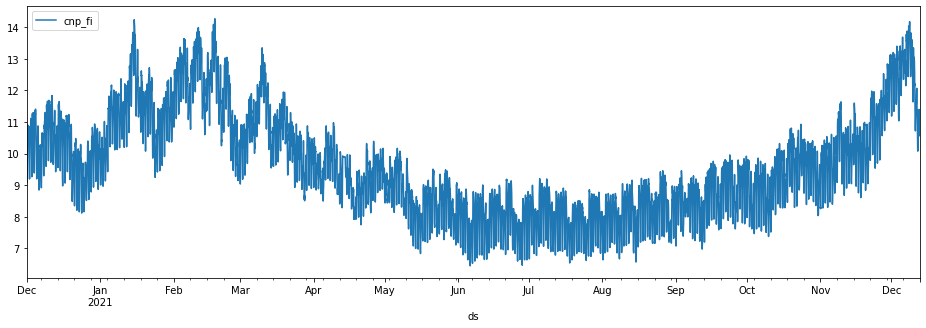

In [239]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import os
import logging
import urllib.parse as url
import warnings
import numpy as np

warnings.filterwarnings("ignore")

data_series = [
    'CNPNP',
    'CNPSE', 'CNPSE1', 'CNPSE2', 'CNPSE3', 'CNPSE4',
    'CNPNO', 'CNPNO1', 'CNPNO2', 'CNPNO3', 'CNPNO4', 'CNPNO5',
    'CNPDEN', 'CNPDK1', 'CNPDK2',
    'CNPFI'
]
column_names = [
    'cnp_np',
    'cnp_se', 'cnp_se1', 'cnp_se2', 'cnp_se3', 'cnp_se4',
    'cnp_no', 'cnp_no1', 'cnp_no2', 'cnp_no3', 'cnp_no4', 'cnp_no5',
    'cnp_dk', 'cnp_dk1', 'cnp_dk2',
    'cnp_fi'
]

history_start_date = datetime(year=2020, month=12, day=1)
history_end_date = datetime(year=2021, month=12, day=5)
forecast_end_date = datetime(year=2021, month=12, day=12)

request = {
    "series": ','.join(data_series),
    'interval': 'hour',
    'start': history_start_date.strftime('%Y-%m-%d'),
    'end': forecast_end_date.strftime('%Y-%m-%d'),
    'token': '8ycj3jSf2DJZOtX',
    #'token': '7EMf0VCcZxcIdBy',
    'emptydata': 'yes',
    'currency': '',
    'dateFormat': 'nbno',
    'numberFormat': 'nothousandsdot',
    'fileformat': 'csv',
    'headers': 'no'
}

dataUrl = f'https://syspower5.skm.no/api/webquery/execute?{url.urlencode(request)}'
data = pd.read_csv(dataUrl, sep=';', index_col=0, parse_dates=True, dayfirst=True,
                   header=None, names = ['ds'] + column_names).interpolate().reset_index()

data.plot(x='ds', y='cnp_fi', figsize=(16, 5))
data.tail(24)

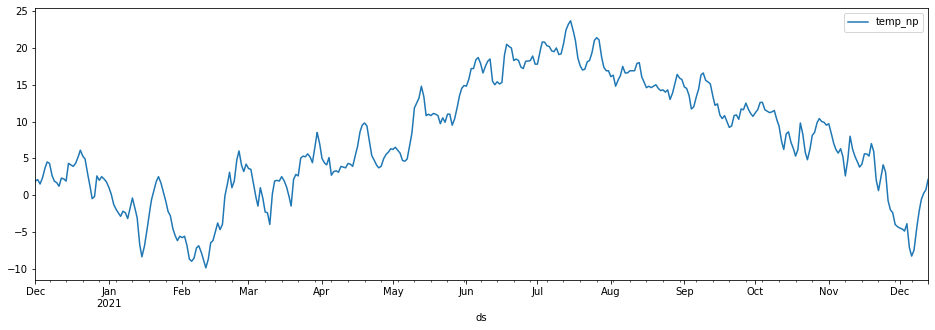

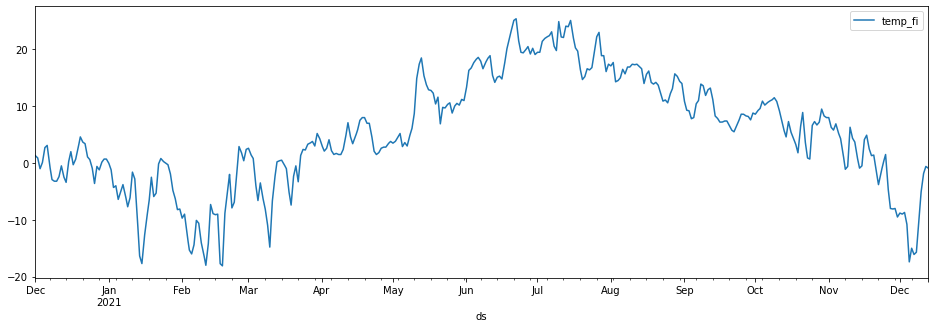

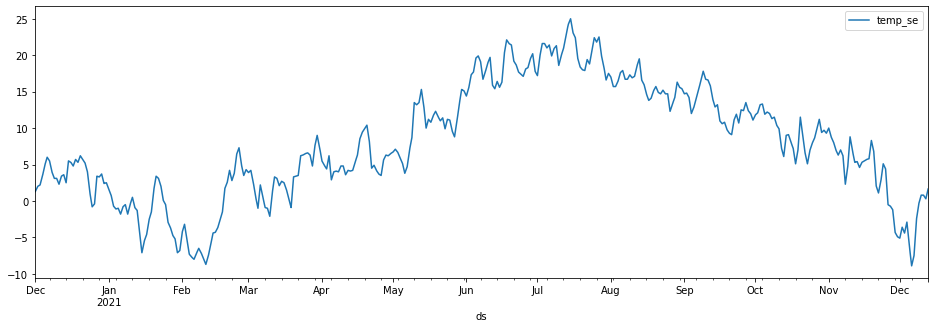

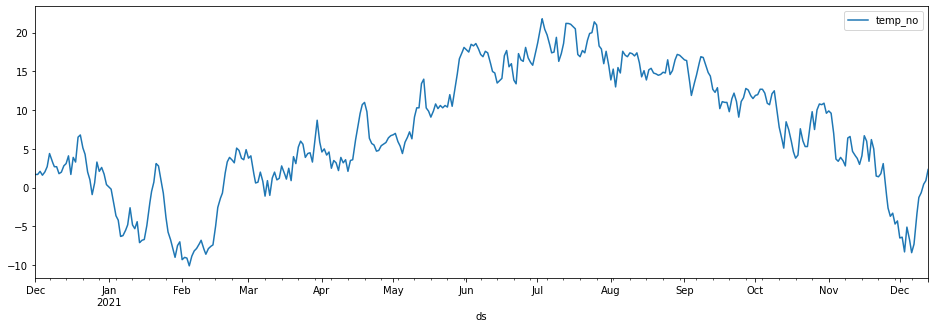

In [240]:
data_series_exog = [
    'SMHITEMPFI_F', 'SMHITEMPSE_F', 'SMHITEMPNO_F', 'SMHITEMPNP_F', 'SMHITEMPDK_F'
]
column_names_exog = [
    'temp_fi', 'temp_se', 'temp_no', 'temp_np', 'temp_dk'
]

temp_date = forecast_end_date + timedelta(days=1)
request = {
    "series": ','.join(data_series_exog),
    'interval': 'day',
    'start': history_start_date.strftime('%Y-%m-%d'),
    'end': temp_date.strftime('%Y-%m-%d'),
    'token': '8ycj3jSf2DJZOtX',
    'emptydata': 'yes',
    'currency': '',
    'dateFormat': 'nbno',
    'numberFormat': 'nothousandsdot',
    'fileformat': 'csv',
    'headers': 'no'
}

dataUrl = f'https://syspower5.skm.no/api/webquery/execute?{url.urlencode(request)}'
temp_data = pd.read_csv(dataUrl, sep=';', index_col=0, parse_dates=True, dayfirst=True,
                        header=None, names = ['ds'] + column_names_exog).interpolate().reset_index()

temp_data['ds'] = pd.to_datetime(temp_data['ds'])
temp_data.set_index('ds', inplace=True)
temp_data = temp_data.resample('H').interpolate()
temp_data = temp_data.reset_index()
temp_data = temp_data[lambda x: x['ds'] < temp_date]
temp_data.plot(x='ds', y='temp_np', figsize=(16, 5))
temp_data.plot(x='ds', y='temp_fi', figsize=(16, 5))
temp_data.plot(x='ds', y='temp_se', figsize=(16, 5))
temp_data.plot(x='ds', y='temp_no', figsize=(16, 5))
data = pd.merge(left=data, right=temp_data, on='ds', how='left')

In [241]:
def create_dataset(df: pd.DataFrame, column_names: list) -> pd.DataFrame:
    result = df.melt(
        id_vars=['ds'],
        value_vars=column_names
    )
    groups_dict = {key: value for value, key in enumerate(column_names)}
    time_idx = np.tile(np.arange(data.shape[0]), len(column_names))
    result['time_idx'] = time_idx
    result['group'] = result.apply(lambda x: groups_dict.get(x['variable'], 0), axis=1)

    result['date'] = result.apply(lambda x: pd.to_datetime(x['ds'].date()), axis=1)
    result['country'] = result.apply(lambda x: x['variable'].split('_')[-1][:2], axis=1)

    special_days = pd.read_excel('syspower_dict.xlsx', 'calendar')
    special_days.columns = ['date', 'country', 'spec_day']
    special_days['country'] = special_days.apply(lambda x: x['country'].lower(), axis=1)
    special_days['spec_day'] = special_days['spec_day'] + 1
    result['weekday'] = result.apply(lambda x: x['ds'].weekday(), axis=1)

    result = pd.merge(left=result, right=special_days, on=['date', 'country'], how='left').fillna(value=0).drop_duplicates().reset_index(drop=True)

    result['day_type'] = result.apply(
        lambda x: 'holiday' if (x['weekday'] == 5 or x['weekday'] == 6 or x['spec_day'] != 0) else 'common',
        axis=1
    )

    result['hour'] = result.apply(lambda x: x['ds'].hour, axis=1).astype(str).astype('category')
    result['weekday'] = result['weekday'].astype(str).astype('category')
    result['month'] = result.apply(lambda x: x['ds'].month, axis=1).astype(str).astype('category')
    result['spec_day'] = result['spec_day'].astype(str).astype('category')

    return result

In [242]:
def add_covariates(df: pd.DataFrame, target_column_names: list) -> pd.DataFrame:
    df_list = [df] * len(target_column_names)
    result_df = pd.concat(df_list, ignore_index=True)
    return result_df

In [243]:
res = create_dataset(df=data, column_names=column_names)
exog_df = add_covariates(df=temp_data, target_column_names=column_names).drop(columns='ds')
res = pd.concat([res, exog_df], axis=1)

In [261]:
res.loc[(res.country == 'fi') & (res.ds == datetime(year=2021, month=12, day=6)), :]

,ds,variable,value,time_idx,group,date,country,weekday,spec_day,day_type,hour,month,temp_fi,temp_se,temp_no,temp_np,temp_dk
144600,2021-12-06,cnp_fi,12.61,8880,15,2021-12-06,fi,0,1.0,holiday,0,12,-15.0,-8.9,-8.4,-8.3,-0.5


In [245]:
res.tail(24)

,ds,variable,value,time_idx,group,date,country,weekday,spec_day,day_type,hour,month,temp_fi,temp_se,temp_no,temp_np,temp_dk
144744,2021-12-12 00:00:00,cnp_fi,10.54,9024,15,2021-12-12,fi,6,0.0,holiday,0,12,-0.6000,0.300000,0.9000,0.7000,2.40
144745,2021-12-12 01:00:00,cnp_fi,10.29,9025,15,2021-12-12,fi,6,0.0,holiday,1,12,-0.6125,0.358333,0.9625,0.7625,2.55
144746,2021-12-12 02:00:00,cnp_fi,10.12,9026,15,2021-12-12,fi,6,0.0,holiday,2,12,-0.6250,0.416667,1.0250,0.8250,2.70
144747,2021-12-12 03:00:00,cnp_fi,10.08,9027,15,2021-12-12,fi,6,0.0,holiday,3,12,-0.6375,0.475000,1.0875,0.8875,2.85
144748,2021-12-12 04:00:00,cnp_fi,10.13,9028,15,2021-12-12,fi,6,0.0,holiday,4,12,-0.6500,0.533333,1.1500,0.9500,3.00
144749,2021-12-12 05:00:00,cnp_fi,10.30,9029,15,2021-12-12,fi,6,0.0,holiday,5,12,-0.6625,0.591667,1.2125,1.0125,3.15
144750,2021-12-12 06:00:00,cnp_fi,10.36,9030,15,2021-12-12,fi,6,0.0,holiday,6,12,-0.6750,0.650000,1.2750,1.0750,3.30
144751,2021-12-12 07:00:00,cnp_fi,10.67,9031,15,2021-12-12,fi,6,0.0,holiday,7,12,-0.6875,0.708333,1.3375,1.1375,3.45
144752,2021-12-12 08:00:00,cnp_fi,10.73,9032,15,2021-12-12,fi,6,0.0,holiday,8,12,-0.7000,0.766667,1.4000,1.2000,3.60
144753,2021-12-12 09:00:00,cnp_fi,10.82,9033,15,2021-12-12,fi,6,0.0,holiday,9,12,-0.7125,0.825000,1.4625,1.2625,3.75


In [246]:
training_data = res[lambda x: x['ds'] < history_end_date]
testing_data = res[lambda x: x['ds'] >= history_end_date]

In [247]:
training_data.tail(24)

,ds,variable,value,time_idx,group,date,country,weekday,spec_day,day_type,hour,month,temp_fi,temp_se,temp_no,temp_np,temp_dk
144552,2021-12-04 00:00:00,cnp_fi,11.30,8832,15,2021-12-04,fi,5,0.0,holiday,0,12,-10.800,-2.900000,-5.100000,-3.900000,2.900000
144553,2021-12-04 01:00:00,cnp_fi,11.11,8833,15,2021-12-04,fi,5,0.0,holiday,1,12,-11.075,-3.033333,-5.158333,-4.033333,2.816667
144554,2021-12-04 02:00:00,cnp_fi,11.04,8834,15,2021-12-04,fi,5,0.0,holiday,2,12,-11.350,-3.166667,-5.216667,-4.166667,2.733333
144555,2021-12-04 03:00:00,cnp_fi,11.04,8835,15,2021-12-04,fi,5,0.0,holiday,3,12,-11.625,-3.300000,-5.275000,-4.300000,2.650000
144556,2021-12-04 04:00:00,cnp_fi,11.19,8836,15,2021-12-04,fi,5,0.0,holiday,4,12,-11.900,-3.433333,-5.333333,-4.433333,2.566667
144557,2021-12-04 05:00:00,cnp_fi,11.49,8837,15,2021-12-04,fi,5,0.0,holiday,5,12,-12.175,-3.566667,-5.391667,-4.566667,2.483333
144558,2021-12-04 06:00:00,cnp_fi,11.64,8838,15,2021-12-04,fi,5,0.0,holiday,6,12,-12.450,-3.700000,-5.450000,-4.700000,2.400000
144559,2021-12-04 07:00:00,cnp_fi,11.97,8839,15,2021-12-04,fi,5,0.0,holiday,7,12,-12.725,-3.833333,-5.508333,-4.833333,2.316667
144560,2021-12-04 08:00:00,cnp_fi,12.16,8840,15,2021-12-04,fi,5,0.0,holiday,8,12,-13.000,-3.966667,-5.566667,-4.966667,2.233333
144561,2021-12-04 09:00:00,cnp_fi,12.25,8841,15,2021-12-04,fi,5,0.0,holiday,9,12,-13.275,-4.100000,-5.625000,-5.100000,2.150000


In [248]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer, MultiNormalizer, EncoderNormalizer
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

pl.seed_everything(666)

encoder_length = 120
decoder_length = 24

training_cutoff = res['time_idx'].max() - decoder_length
training_dataset = TimeSeriesDataSet(
    training_data[lambda x: x.time_idx <= training_cutoff],
    group_ids=['group'],
    target='value',
    time_idx='time_idx',
    min_encoder_length=encoder_length,
    max_encoder_length=encoder_length,
    min_prediction_length=decoder_length,
    max_prediction_length=decoder_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=column_names_exog,
    time_varying_known_categoricals=['hour', 'weekday', 'month', 'day_type', 'country'],
    scalers={'std_scale': EncoderNormalizer()},
    target_normalizer=EncoderNormalizer(),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
    #scalers={'encoder_normalizer': EncoderNormalizer()},
)
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    training_data,
    predict=True,
    stop_randomization=True
)
batch_size = 64
train_dataloader = training_dataset.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=0
)
val_dataloader = validation_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    num_workers=0
)

Global seed set to 666


In [249]:
import pytorch_forecasting as pf
from pytorch_forecasting.metrics import SMAPE, QuantileLoss
# {'gradient_clip_val': 0.1120722231081914, 'hidden_size': 184, 'dropout': 0.21623306917480986, 'hidden_continuous_size': 56, 'attention_head_size': 3, 'learning_rate': 0.008311925176871819}
model = pf.DeepAR.from_dataset(
    training_dataset,
    hidden_size=32,
    rnn_layers=3,
    cell_type='GRU',
    learning_rate=1e-3
)

In [250]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary='top',
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    gradient_clip_val=0.112
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [251]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)


  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 345   
3 | rnn                    | GRU                    | 19.3 K
4 | distribution_projector | Linear                 | 66    
------------------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 666


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [252]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = pf.DeepAR.load_from_checkpoint(best_model_path)

In [253]:
# raw_predictions, x = model.predict(val_dataloader, mode='raw', return_x=True)
# for index in range(len(column_names)):
#     best_model.plot_prediction(x, raw_predictions, idx=index, add_loss_to_title=True)

In [254]:
data['cnp_fi_pred'] = 0

dates_range = pd.date_range(
    start=history_end_date + timedelta(hours=decoder_length),
    end=forecast_end_date,
    freq='D'
)
for current_date in dates_range:
    cur_df = res.loc[
             (res['ds'] >= current_date - timedelta(hours=encoder_length+decoder_length)) &
             (res['ds'] < current_date),
             :
        ]
    prediction = best_model.predict(
        cur_df,
        mode='prediction',
        return_x=False
    )
    data.loc[
        (data['ds'] >= current_date - timedelta(hours=decoder_length)) &
        (data['ds'] < current_date),
        'cnp_fi_pred'
    ] = prediction.detach().numpy()[-1, :]

<AxesSubplot:xlabel='ds'>

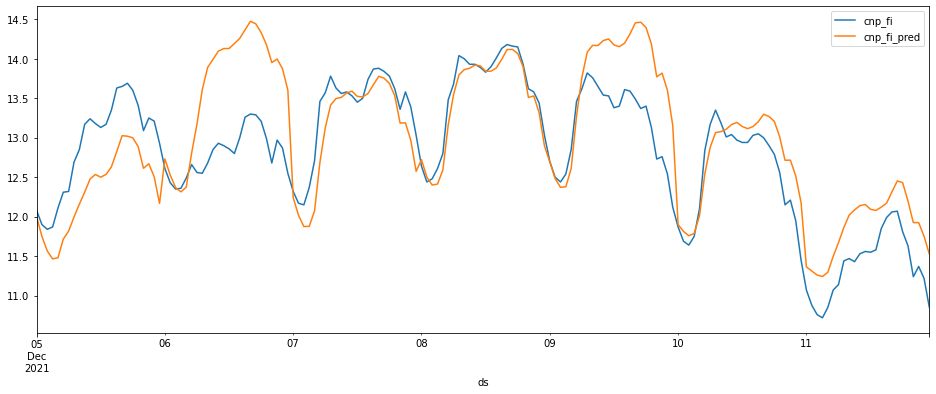

In [255]:
forecast_results = data.loc[
    (data['ds'] >= history_end_date) &
    (data['ds'] < forecast_end_date),
    ['ds', 'cnp_fi', 'cnp_fi_pred']
].set_index('ds')
forecast_results.plot(figsize=(16, 6))

In [256]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(
    y_true=forecast_results.loc[:, 'cnp_fi'],
    y_pred=forecast_results.loc[:, 'cnp_fi_pred']
)
print(f'MAE = {mae}')

MAE = 0.4523536153066726


In [257]:
forecast_results.reset_index(inplace=True)

In [258]:
forecast_results['day'] = forecast_results.apply(lambda x: x['ds'].day, axis=1)
forecast_results['hour'] = forecast_results.apply(lambda x: x['ds'].hour, axis=1)
forecast_results['diff'] = forecast_results.apply(lambda x: np.abs(x['cnp_fi'] - x['cnp_fi_pred']), axis=1)
diff = forecast_results.groupby(by='day').max()['diff'].to_numpy()
#diff
#diff = diff[diff <= 1]
np.mean(diff * 1000)

835.5088915143697

In [259]:
#forecast_results.to_csv('forecasting_results_deepar.csv')

In [260]:
diff

array([0.85995094, 1.39256592, 0.77172276, 0.31763885, 1.09303177,
       0.72848873, 0.68516327])